## Feature selection using two-stage filtering method  
We applied a two-stage filtering feature selection method for bow and tfi-df approaches only.    
filter 1 - remove feature with low variance
filter 2 - remove redundant features using MI score

| Using all features bow1:    | LR = 0.7389736477115117 | (6459 features) |
|-----------------------------|-------------------------|-----------------|
| With our two-stage FS bow1: | LR = 0.7147018030513176 | (1394 features) |

pree.t@cmu.ac.th  

In [1]:
import joblib
import os
import numpy as np
from scipy import sparse
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt

os.path.dirname(os.getcwd())

model_path = os.path.dirname(os.getcwd()) + '\\model\\'
lexicon_path = os.path.dirname(os.getcwd()) + '\\lexicon\\'

In [2]:
# preparing all data that need to calculate the MI score
text_bow1_kt = joblib.load(model_path+'text_bow1_kt.pkl')
lex_bow_kt = joblib.load(lexicon_path+'lex_bow1_kt.pkl')

X, y = text_bow1_kt
X = X.A
y = y.A

print(X.shape)
print(y.shape)

(60081, 6459)
(60081, 1)


## Filter 1 - remove features with low variance

In [3]:
from sklearn.feature_selection import VarianceThreshold
# 0.00035 removed 3755
# 0.001 removed 5138
# 0.003 removed 5925
vt = VarianceThreshold(threshold=0.00035)
vt.fit(X)
col_thr = vt.get_support()

In [4]:
idx = np.where(col_thr==False)
print("total number of feature will be removed:", len(idx[0]))
X_vt =  np.delete(X, idx, 1)
X_vt.shape

total number of feature will be removed: 3755


(60081, 2704)

## Filter 2 remove using MI score

In [5]:
#calcuate mi score of the remaining terms
feature_scores = mutual_info_classif(X_vt, np.ravel(y), random_state=0)

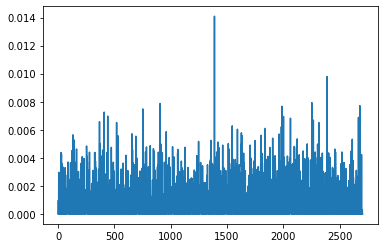

In [6]:
plt.plot(feature_scores)

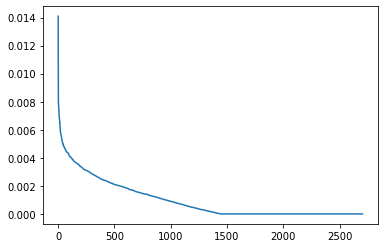

In [7]:
# set another mi score threshold manually, so that we can have reasonable size
plt.plot(-np.sort(-feature_scores))

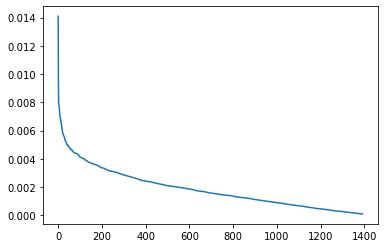

In [8]:
feature_scores_final = feature_scores[feature_scores > 0.00010]
plt.plot(-np.sort(-feature_scores_final))

In [9]:
mi_idx = np.argwhere(feature_scores > 0.00010)
X_vt_mi = np.take(X_vt, mi_idx.flatten(), axis=1)
X_vt_mi.shape

(60081, 1393)

In [10]:
arr_kt_new = np.hstack((sparse.csr_matrix(X_vt_mi), sparse.csr_matrix(y)))
#joblib.dump(arr_kt_new, model_path+'text_bow1_kt_fs.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_bow1_kt_fs.pkl']

## Test with LR

In [11]:
arr_kt_new = np.concatenate((X_vt_mi, y), axis=1)

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

In [13]:
train_df, test_df = train_test_split(arr_kt_new, test_size=0.20, random_state=42)
train_df.shape, test_df.shape

((48064, 1394), (12017, 1394))

In [14]:
#arr_kt_old = np.concatenate((X, y), axis=1)
arr_kt_new = np.concatenate((X_vt_mi, y), axis=1)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[:,:-1], train_df[:,-1], test_size=0.15, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((40854, 1393), (7210, 1393), (40854,), (7210,))

In [16]:
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train, y_train)
model.score(X_valid, y_valid)

0.7147018030513176